In [2]:
import random
import math
import numpy as np


class Neuron():
    '''
        A conceptual Neuron hat can be trained using a 
        fit and predict methodology, without any library
    '''
    
    def __init__(self, position_in_layer, is_output_neuron=False, is_sigmoid=True):
        self.weights = []
        self.inputs = []
        self.output = None
        
        # This is used for the backpropagation update
        self.updated_weights = []
        # This is used to know how to update the weights
        self.is_output_neuron = is_output_neuron
        # This delta is used for the update at the backpropagation
        self.delta = None
        # This is used for the backpropagation update
        self.position_in_layer = position_in_layer 
        self.is_sigmoid = is_sigmoid
        
    def attach_to_output(self, neurons):
        '''
            Helper function to store the reference of the other neurons
            To this particular neuron (used for backpropagation)
        '''
        
        self.output_neurons = neurons
    
    def activation(self, x):
        if self.is_sigmoid:
            return self.sigmoid(x)
        else:
            return self.Linear(x)

    def activationDerive(self, x):
        if self.is_sigmoid:
            return self.sigmoidDerive(x)
        else:
            return self.LinearDerive(x)
    
    def sigmoid(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        if isinstance(x, list):
            print(x)
        return 1 / (1 + math.exp(-x))

    def sigmoidDerive(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        return x*(1-x)

    def Linear(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        return x

    def LinearDerive(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        return 1
    
    def init_weights(self, num_input):
        '''
            This is used to setup the weights when we know how many inputs there is for
            a given neuron
        '''
        
        # Randomly initalize the weights
        for i in range(num_input+1):
            self.weights.append(random.uniform(0,1))
        
    def predict(self, row):
        '''
            Given a row of data it will predict what the output should be for
            this given neuron. We can have many input, but only one output for a neuron
        '''
        
        # Reset the inputs
        self.inputs = []
        
        # We iterate over the weights and the features in the given row
        activation = 0
        for weight, feature in zip(self.weights, row):
            self.inputs.append(feature)
            activation = activation + weight*feature
            
        
        self.output = self.activation(activation)
        return self.output
    
        
            
    def update_neuron(self):
        '''
            Will update a given neuron weights by replacing the current weights
            with those used during the backpropagation. This need to be done at the end of the
            backpropagation
        '''
        
        self.weights = []
        for new_weight in self.updated_weights:
            self.weights.append(new_weight)
    
    def calculate_update(self, learning_rate, target):
        '''
            This function will calculate the updated weights for this neuron. It will first calculate
            the right delta (depending if this neuron is a ouput or a hidden neuron), then it will
            calculate the right updated_weights. It will not overwrite the weights yet as they are needed
            for other update in the backpropagation algorithm.
        '''
        derive = self.activationDerive(self.output)
        if self.is_output_neuron:
            # Calculate the delta for the output
            self.delta = (self.output - target)*derive
        else:
            # Calculate the delta
            delta_sum = 0
            # this is to know which weights this neuron is contributing in the output layer
            cur_weight_index = self.position_in_layer 
            for output_neuron in self.output_neurons:
                delta_sum = delta_sum + (output_neuron.delta * output_neuron.weights[cur_weight_index])

            # Update this neuron delta
            self.delta = delta_sum*derive
            
            
        # Reset the update weights
        self.updated_weights = []
        
        # Iterate over each weight and update them
        for cur_weight, cur_input in zip(self.weights, self.inputs):
            gradient = self.delta*cur_input
            new_weight = cur_weight - learning_rate*gradient
            self.updated_weights.append(new_weight)

    def toString(self):
        print(self.weights)
         
class Layer():
    '''
        Layer is modelizing a layer in the fully-connected-feedforward neural network architecture.
        It will play the role of connecting everything together inside and will be doing the backpropagation 
        update.
    '''
    
    def __init__(self, num_neuron, is_output_layer = False, is_sigmoid=True):
        
        # Will create that much neurons in this layer
        self.is_output_layer = is_output_layer
        self.neurons = []
        for i in range(num_neuron):
            # Create neuron
            neuron = Neuron(i,  is_output_neuron=is_output_layer, is_sigmoid=is_sigmoid)
            self.neurons.append(neuron)
    
    def attach(self, layer):
        '''
            This function attach the neurons from this layer to another one
            This is needed for the backpropagation algorithm
        '''
        # Iterate over the neurons in the current layer and attach 
        # them to the next layer
        for in_neuron in self.neurons:
            in_neuron.attach_to_output(layer.neurons)
            
    def init_layer(self, num_input):
        '''
            This will initialize the weights of each neuron in the layer.
            By giving the right num_input it will spawn the right number of weights
        '''
        
        # Iterate over each of the neuron and initialize
        # the weights that connect with the previous layer
        for neuron in self.neurons:
            neuron.init_weights(num_input)
    
    def predict(self, row):
        '''
            This will calcualte the activations for the full layer given the row of data 
            streaming in.
        '''
        rowClone = row.copy()
        rowClone = np.append(rowClone, [1]) # need to add the bias
        activations = [neuron.predict(rowClone) for neuron in self.neurons]
        return activations

    def toString(self):
        for neuron in self.neurons:
            neuron.toString(); 
        
class MultiLayerPerceptron():
    '''
        We will be creating the multi-layer perceptron with only two layer:
        an input layer, a perceptrons layer and a one neuron output layer which does binary classification
    '''
    def __init__(self, learning_rate = 0.01, num_iteration = 100, is_Classifier=True):
        
        random.seed(5)
        # Layers
        self.layers = []
                
        # Training parameters
        self.learning_rate = learning_rate
        self.num_iteration = num_iteration
        self.is_Classifier = is_Classifier
        
        
    def add_output_layer(self, num_neuron, is_sigmoid=True):
        '''
            This helper function will create a new output layer and add it to the architecture
        '''
        self.layers.insert(0, Layer(num_neuron, is_output_layer = True, is_sigmoid=is_sigmoid))
    
    def add_hidden_layer(self, num_neuron):
        '''
            This helper function will create a new hidden layer, add it to the architecture
            and finally attach it to the front of the architecture
        '''
        # Create an hidden layer
        hidden_layer = Layer(num_neuron)
        # Attach the last added layer to this new layer
        hidden_layer.attach(self.layers[0])
        # Add this layers to the architecture
        self.layers.insert(0, hidden_layer)
        
    def update_layers(self, target):
        '''
            Will update all the layers by calculating the updated weights and then updating 
            the weights all at once when the new weights are found.
        '''
        # Iterate over each of the layer in reverse order
        # to calculate the updated weights
        for layer in reversed(self.layers):
                           
            # Calculate update the hidden layer
            for neuron in layer.neurons:
                neuron.calculate_update(self.learning_rate, target)  
        
        # Iterate over each of the layer in normal order
        # to update the weights
        for layer in self.layers:
            for neuron in layer.neurons:
                neuron.update_neuron()
    
    def train(self, X, y):
        '''
            Main training function of the neural network algorithm. This will make use of backpropagation.
            It will use stochastic gradient descent by selecting one row at random from the dataset and 
            use predict to calculate the error. The error will then be backpropagated and new weights calculated.
            Once all the new weights are calculated, the whole network weights will be updated
        '''

        
        num_row = len(X)
        num_feature = len(X[0]) # Here we assume that we have a rectangular matrix
        
        # Init the weights throughout each of the layer
        self.layers[0].init_layer(num_feature)
        
        for i in range(1, len(self.layers)):
            num_input = len(self.layers[i-1].neurons)
            self.layers[i].init_layer(num_input)
        
        #self.toString()

        # Launch the training algorithm
        for i in range(self.num_iteration):
            
            # Stochastic Gradient Descent
            r_i = random.randint(0,num_row-1)
            row = X[r_i] # take the random sample from the dataset
            yhat = self.predict(row)
            target = y[r_i]
            
            # Update the layers using backpropagation   
            self.update_layers(target)
            
            # At every 100 iteration we calculate the error
            # on the whole training set
            if i % 100 == 0:
                total_error = 0

                for r_i in range(num_row):
                    row = X[r_i]
                    yhat = self.predict(row)
                    error = (y[r_i] - yhat)
                    total_error = total_error + error**2
                mean_error = total_error/num_row
                print(f"Iteration {i} with error = {mean_error}")
                
        #self.toString()
        
    
    def predict(self, row):
        '''
            Prediction function that will take a row of input and give back the output
            of the whole neural network.
        '''
        
        # Gather all the activation in the hidden layer
        
        activations = self.layers[0].predict(row)
        for i in range(1, len(self.layers)):
            activations = self.layers[i].predict(activations)

        outputs = []

        for activation in activations:
            if self.is_Classifier :
                # Decide if we output a 1 or 0
                if activation >= 0.5:
                    outputs.append(1.0)
                else:
                    outputs.append(0.0)
            else:
                outputs.append(activation)

                           
        # We currently have only One output allowed
        return outputs[0]

    def validate(self, rows, rowValidate):
        num_row = len(rows)

        total_error = 0

        for r_i in range(num_row):
            row = rows[r_i]
            yhat = self.predict(row)
            error = (y[r_i] - yhat)
            total_error = total_error + error**2
        mean_error = total_error/num_row
        print(f"Iteration {i} with error = {mean_error}")


    def toString(self):
        for i, layer in enumerate(self.layers):
            print("Layer"+str(i))
            layer.toString()


In [3]:
# XOR function (one or the other but not both)
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([0, 1, 1, 0])

# Init the parameters for the network
clf = MultiLayerPerceptron(learning_rate = 0.5, num_iteration = 100000)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1)
#clf.add_hidden_layer(num_neuron = 3)
clf.add_hidden_layer(num_neuron = 2)
# Train the network
clf.train(X,y)

Layer0
[0.6229016948897019, 0.7417869892607294, 0.7951935655656966]
[0.9424502837770503, 0.7398985747399307, 0.922324996665417]
Layer1
[0.029005228283614737, 0.46562265437810535, 0.9433567169983137]
Iteration 0 with error = 0.5
Iteration 10000 with error = 0.0
Iteration 20000 with error = 0.0
Iteration 30000 with error = 0.0
Iteration 40000 with error = 0.0
Iteration 50000 with error = 0.0
Iteration 60000 with error = 0.0
Iteration 70000 with error = 0.0
Iteration 80000 with error = 0.0
Iteration 90000 with error = 0.0
Layer0
[4.894069078311957, 4.902513295574223, -7.51599992979117]
[6.804556223570668, 6.832792275230364, -3.0754123531554205]
Layer1
[-11.244196642530676, 10.52821968186535, -4.909593041931376]


In [4]:
print("Expected 0.0, got: ",clf.predict([0,0]))
print("Expected 1.0, got: ",clf.predict([0,1]))
print("Expected 1.0, got: ",clf.predict([1,0]))
print("Expected 0.0, got: ",clf.predict([1,1]))


Expected 0.0, got:  0.0
Expected 1.0, got:  1.0
Expected 1.0, got:  1.0
Expected 0.0, got:  0.0


In [5]:
import numpy as np
# 1. Creation of test data set

X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      2,
      3,
      2.5
])


# Init the parameters for the network
clf = MultiLayerPerceptron(learning_rate = 0.05, num_iteration = 100000, is_Classifier = False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 5)
# Train the network
clf.train(X,Y)


Layer0
[0.6229016948897019, 0.7417869892607294]
[0.7951935655656966, 0.9424502837770503]
[0.7398985747399307, 0.922324996665417]
[0.029005228283614737, 0.46562265437810535]
[0.9433567169983137, 0.6489745531369242]
Layer1
[0.9009004917506227, 0.11320596465314436, 0.46906904778216374, 0.24657283261983032, 0.5437608592359304, 0.5739411879281008]
Iteration 0 with error = 0.12512867255686413
Iteration 10000 with error = 0.0508024048067219
Iteration 20000 with error = 0.0005740217020324812
Iteration 30000 with error = 7.019788673630293e-08
Iteration 40000 with error = 5.616885089795582e-12
Iteration 50000 with error = 6.311150612722709e-16
Iteration 60000 with error = 7.215746722103003e-20
Iteration 70000 with error = 8.416529298172356e-24
Iteration 80000 with error = 7.192439303352575e-28
Iteration 90000 with error = 1.0518145402946823e-30
Layer0
[2.8245779778904674, -2.3878341052405223]
[0.47721395054360394, 0.2380056219798162]
[1.7017119033945256, 0.42518754329611186]
[0.9136638742670695,

In [6]:
print("Expected 2, got: ",clf.predict([1]))
print("Expected 3, got: ",clf.predict([2]))
print("Expected 2.5, got: ",clf.predict([3]))

Expected 2, got:  1.9999999999999998
Expected 3, got:  2.999999999999999
Expected 2.5, got:  2.500000000000001


In [7]:
# 1. Creation of test data set

X = np.array([
      [1, 1],
      [2, 2],
      [3, 1]
])
Y = np.array([
      2,
      3,
      2.5
])

# Init the parameters for the network
clf = MultiLayerPerceptron(learning_rate = 0.1, num_iteration = 100000, is_Classifier = False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 10)
# Train the network
clf.train(X,Y)

Layer0
[0.6229016948897019, 0.7417869892607294, 0.7951935655656966]
[0.9424502837770503, 0.7398985747399307, 0.922324996665417]
[0.029005228283614737, 0.46562265437810535, 0.9433567169983137]
[0.6489745531369242, 0.9009004917506227, 0.11320596465314436]
[0.46906904778216374, 0.24657283261983032, 0.5437608592359304]
[0.5739411879281008, 0.013114189588902203, 0.21672980046384815]
[0.2794823660111103, 0.9163453718085519, 0.7657254516291417]
[0.15960421235803823, 0.7971469914312045, 0.13876741839890316]
[0.6174525204661166, 0.1266992325502697, 0.0017748622025346439]
[0.8714047447242821, 0.2094563824951179, 0.21548116922473226]
Layer1
[0.9824211088259253, 0.8724077654368019, 0.2893051677469265, 0.9614779889500835, 0.5392234688708106, 0.6778304772505923, 0.20477951453379284, 0.9409760010879991, 0.6906419411069082, 0.9665643123171954, 0.8937416775764785]
Iteration 0 with error = 0.4957854564830943
Iteration 10000 with error = 2.3458856350463867e-25
Iteration 20000 with error = 0.0
Iteration 3

In [8]:
print("Expected 2, got: ",clf.predict([1, 1]))
print("Expected 3, got: ",clf.predict([2, 2]))
print("Expected 2.5, got: ",clf.predict([3, 1]))

Expected 2, got:  2.0
Expected 3, got:  3.0
Expected 2.5, got:  2.5


In [9]:
# 1. Creation of test data set

X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
      2,
      1,
      -2,
      -1
])
# Init the parameters for the network
clf = MultiLayerPerceptron(learning_rate = 0.1, num_iteration = 100000, is_Classifier = False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 2)
clf.add_hidden_layer(num_neuron = 5)
# Train the network
clf.train(X,Y)

Layer0
[0.6229016948897019, 0.7417869892607294, 0.7951935655656966]
[0.9424502837770503, 0.7398985747399307, 0.922324996665417]
[0.029005228283614737, 0.46562265437810535, 0.9433567169983137]
[0.6489745531369242, 0.9009004917506227, 0.11320596465314436]
[0.46906904778216374, 0.24657283261983032, 0.5437608592359304]
Layer1
[0.5739411879281008, 0.013114189588902203, 0.21672980046384815, 0.2794823660111103, 0.9163453718085519, 0.7657254516291417]
[0.15960421235803823, 0.7971469914312045, 0.13876741839890316, 0.6174525204661166, 0.1266992325502697, 0.0017748622025346439]
Layer2
[0.8714047447242821, 0.2094563824951179, 0.21548116922473226]
Iteration 0 with error = 3.7764242300194795
Iteration 10000 with error = 2.317736223709652e-22
Iteration 20000 with error = 1.639351568662415e-30
Iteration 30000 with error = 8.38164711797325e-31
Iteration 40000 with error = 5.669937756276022e-31
Iteration 50000 with error = 1.7256332301709633e-31
Iteration 60000 with error = 1.9721522630525295e-31
Iterat

In [10]:
print("Expected 2, got: ",clf.predict([1, 0]))
print("Expected 1, got: ",clf.predict([0, 1]))
print("Expected -2, got: ",clf.predict([1, 1]))
print("Expected -1, got: ",clf.predict([0, 0]))


Expected 2, got:  2.0
Expected 1, got:  1.0
Expected -2, got:  -2.0
Expected -1, got:  -0.9999999999999998


In [11]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      1,
      2,
      3
])
# Init the parameters for the network
clf = MultiLayerPerceptron(learning_rate = 0.1, num_iteration = 100000, is_Classifier = False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 4)
clf.add_hidden_layer(num_neuron = 2)
# Train the network
clf.train(X,Y)

Layer0
[0.6229016948897019, 0.7417869892607294, 0.7951935655656966]
[0.9424502837770503, 0.7398985747399307, 0.922324996665417]
Layer1
[0.029005228283614737, 0.46562265437810535, 0.9433567169983137]
[0.6489745531369242, 0.9009004917506227, 0.11320596465314436]
[0.46906904778216374, 0.24657283261983032, 0.5437608592359304]
[0.5739411879281008, 0.013114189588902203, 0.21672980046384815]
Layer2
[0.2794823660111103, 0.9163453718085519, 0.7657254516291417, 0.15960421235803823, 0.7971469914312045]
Iteration 0 with error = 0.652476247467049
Iteration 10000 with error = 1.1432780318744011e-26
Iteration 20000 with error = 0.0
Iteration 30000 with error = 0.0
Iteration 40000 with error = 0.0
Iteration 50000 with error = 0.0
Iteration 60000 with error = 0.0
Iteration 70000 with error = 0.0
Iteration 80000 with error = 0.0
Iteration 90000 with error = 0.0
Layer0
[0.5479002402027393, 0.6667855345737654, -2.5180206246879737]
[0.49729347389547696, 0.2947417648583583, -1.0166073855153062]
Layer1
[-0.9

In [12]:
print("Expected 1, got: ",clf.predict([1, 1]))
print("Expected 2, got: ",clf.predict([2, 2]))
print("Expected 3, got: ",clf.predict([3, 3]))

Expected 1, got:  1.0
Expected 2, got:  2.0
Expected 3, got:  3.0


In [13]:
#GOOD
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])
# Init the parameters for the network
clf = MultiLayerPerceptron(learning_rate = 0.6, num_iteration = 100000, is_Classifier = False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 4)
clf.add_hidden_layer(num_neuron = 3)
# Train the network
clf.train(X,Y)

Layer0
[0.6229016948897019, 0.7417869892607294, 0.7951935655656966]
[0.9424502837770503, 0.7398985747399307, 0.922324996665417]
[0.029005228283614737, 0.46562265437810535, 0.9433567169983137]
Layer1
[0.6489745531369242, 0.9009004917506227, 0.11320596465314436, 0.46906904778216374]
[0.24657283261983032, 0.5437608592359304, 0.5739411879281008, 0.013114189588902203]
[0.21672980046384815, 0.2794823660111103, 0.9163453718085519, 0.7657254516291417]
[0.15960421235803823, 0.7971469914312045, 0.13876741839890316, 0.6174525204661166]
Layer2
[0.1266992325502697, 0.0017748622025346439, 0.8714047447242821, 0.2094563824951179, 0.21548116922473226]
Iteration 0 with error = [1.42718673]
Iteration 10000 with error = [0.00141865]
Iteration 20000 with error = [0.00095781]
Iteration 30000 with error = [0.00035247]
Iteration 40000 with error = [0.0003229]
Iteration 50000 with error = [0.00010845]
Iteration 60000 with error = [7.11319543e-05]
Iteration 70000 with error = [7.36919421e-05]
Iteration 80000 wi

In [14]:
#TEST


  0%|          | 0/207 [00:00<?, ?it/s]

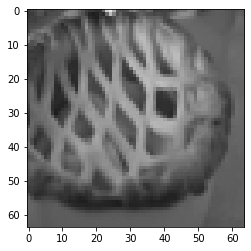

  0%|          | 1/207 [00:00<01:13,  2.81it/s]

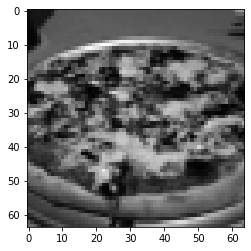

  1%|          | 2/207 [00:00<01:09,  2.96it/s]

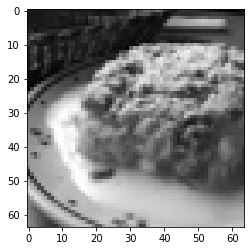

  1%|▏         | 3/207 [00:00<00:57,  3.56it/s]

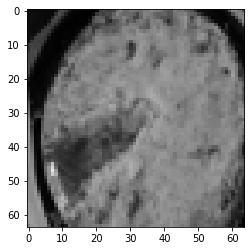

  2%|▏         | 4/207 [00:01<00:55,  3.68it/s]

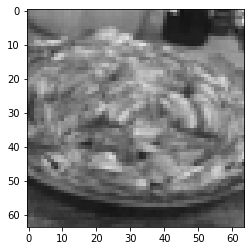

  2%|▏         | 5/207 [00:01<00:50,  4.01it/s]

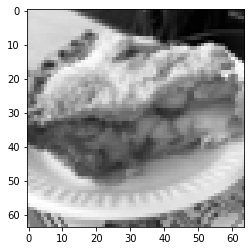

  3%|▎         | 6/207 [00:01<00:49,  4.08it/s]

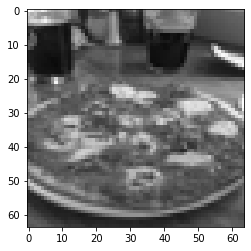

  3%|▎         | 7/207 [00:01<00:46,  4.33it/s]

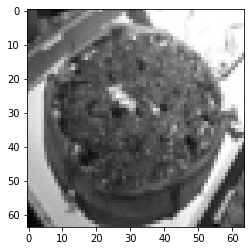

  4%|▍         | 8/207 [00:02<00:45,  4.33it/s]

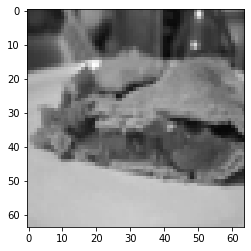

  4%|▍         | 9/207 [00:02<00:50,  3.89it/s]

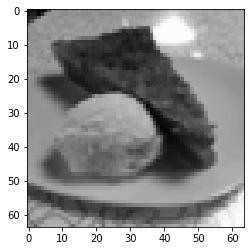

  5%|▍         | 10/207 [00:02<00:46,  4.21it/s]

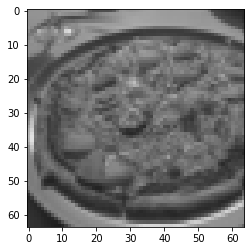

  5%|▌         | 11/207 [00:02<00:46,  4.23it/s]

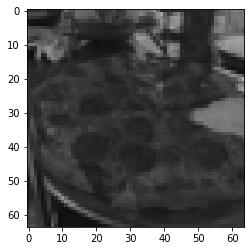

  6%|▌         | 12/207 [00:02<00:42,  4.56it/s]

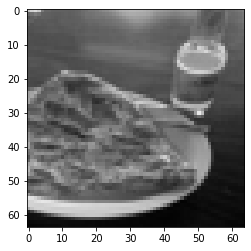

  6%|▋         | 13/207 [00:03<00:41,  4.66it/s]

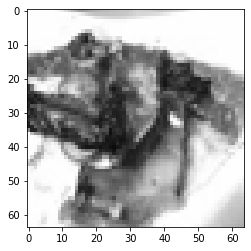

  7%|▋         | 14/207 [00:03<00:40,  4.74it/s]

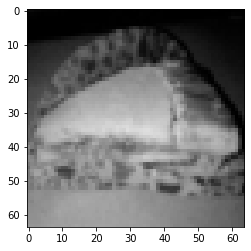

  7%|▋         | 15/207 [00:03<00:39,  4.86it/s]

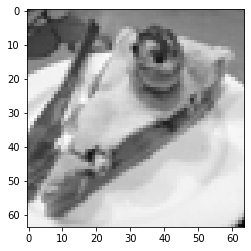

  8%|▊         | 16/207 [00:03<00:39,  4.86it/s]

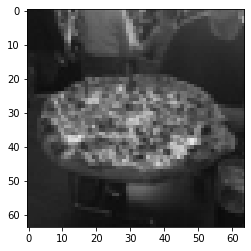

  8%|▊         | 17/207 [00:03<00:40,  4.65it/s]

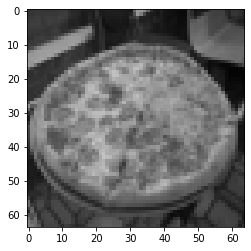

  9%|▊         | 18/207 [00:04<00:38,  4.88it/s]

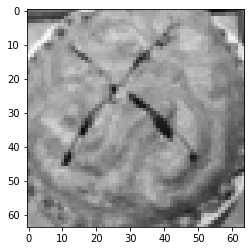

  9%|▉         | 19/207 [00:04<00:41,  4.58it/s]

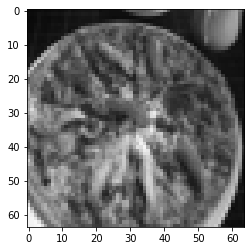

 10%|▉         | 20/207 [00:04<00:38,  4.89it/s]

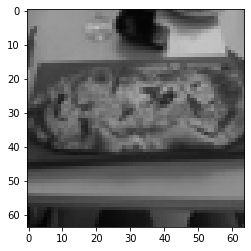

 10%|█         | 21/207 [00:04<00:36,  5.12it/s]

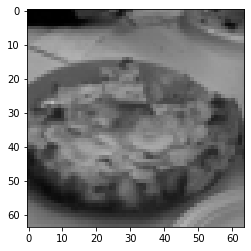

 11%|█         | 22/207 [00:05<00:43,  4.23it/s]

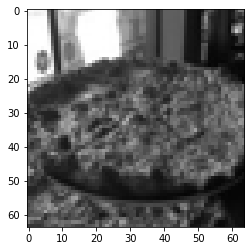

 11%|█         | 23/207 [00:05<00:43,  4.27it/s]

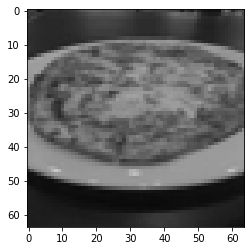

 12%|█▏        | 24/207 [00:05<00:38,  4.75it/s]

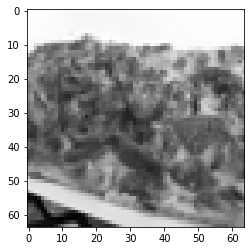

 12%|█▏        | 25/207 [00:05<00:36,  4.93it/s]

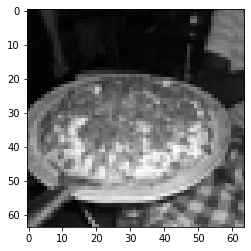

 13%|█▎        | 26/207 [00:05<00:33,  5.37it/s]

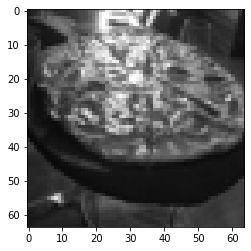

 13%|█▎        | 27/207 [00:06<00:33,  5.32it/s]

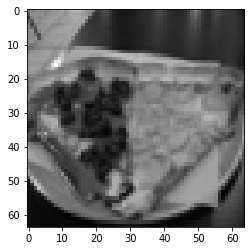

 14%|█▎        | 28/207 [00:06<00:35,  5.06it/s]

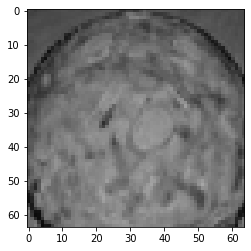

 14%|█▍        | 29/207 [00:06<00:34,  5.20it/s]

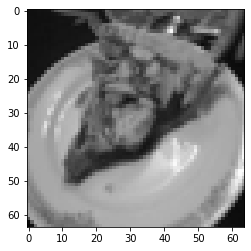

 14%|█▍        | 30/207 [00:06<00:34,  5.19it/s]

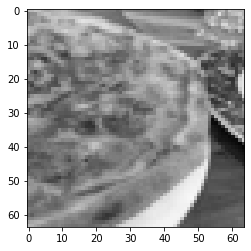

 15%|█▍        | 31/207 [00:06<00:33,  5.28it/s]

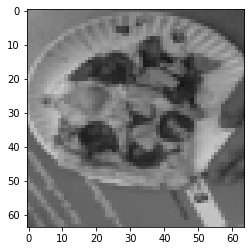

 15%|█▌        | 32/207 [00:06<00:33,  5.30it/s]

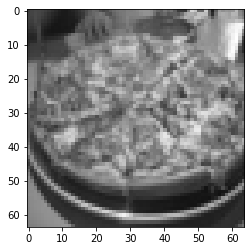

 16%|█▌        | 33/207 [00:07<00:32,  5.34it/s]

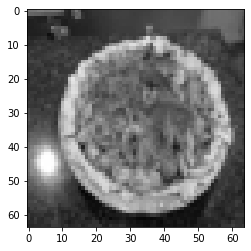

 16%|█▋        | 34/207 [00:07<00:39,  4.38it/s]

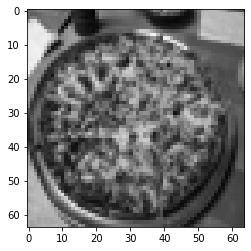

 17%|█▋        | 35/207 [00:07<00:43,  3.92it/s]

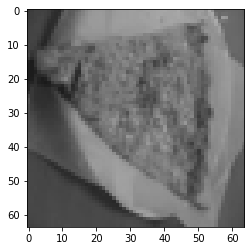

 17%|█▋        | 36/207 [00:08<00:41,  4.15it/s]

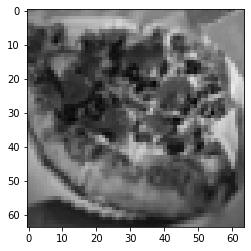

 18%|█▊        | 37/207 [00:08<00:40,  4.16it/s]

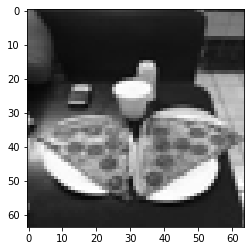

 18%|█▊        | 38/207 [00:08<00:42,  4.00it/s]

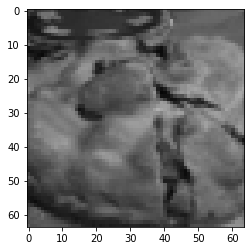

 19%|█▉        | 39/207 [00:08<00:41,  4.01it/s]

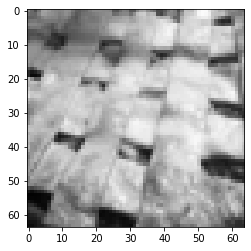

 19%|█▉        | 40/207 [00:09<00:43,  3.88it/s]

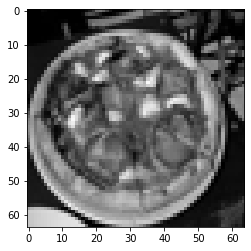

 20%|█▉        | 41/207 [00:09<00:45,  3.66it/s]

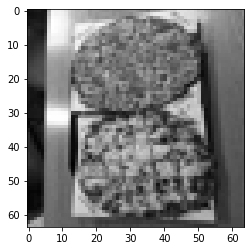

 20%|██        | 42/207 [00:09<00:49,  3.32it/s]

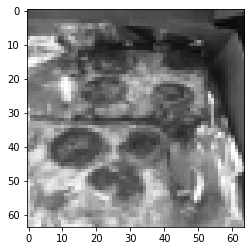

 21%|██        | 43/207 [00:10<00:49,  3.34it/s]

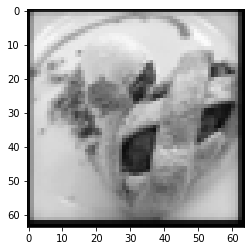

 21%|██▏       | 44/207 [00:10<00:47,  3.44it/s]

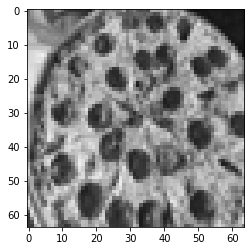

 22%|██▏       | 45/207 [00:10<00:47,  3.40it/s]

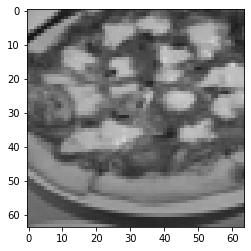

 22%|██▏       | 46/207 [00:10<00:50,  3.19it/s]

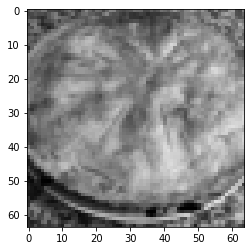

 23%|██▎       | 47/207 [00:11<00:49,  3.23it/s]

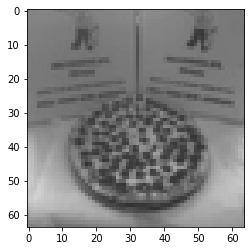

 23%|██▎       | 48/207 [00:11<00:55,  2.85it/s]

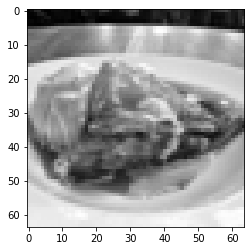

 24%|██▎       | 49/207 [00:12<00:55,  2.87it/s]

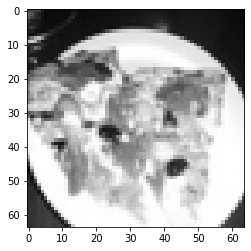

 24%|██▍       | 50/207 [00:12<00:51,  3.07it/s]

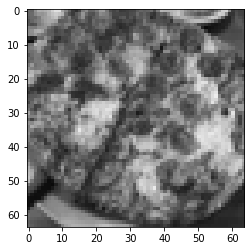

 25%|██▍       | 51/207 [00:12<00:51,  3.01it/s]

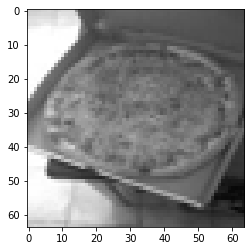

 25%|██▌       | 52/207 [00:12<00:49,  3.11it/s]

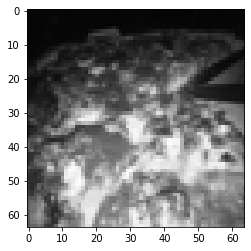

 26%|██▌       | 53/207 [00:13<00:50,  3.03it/s]

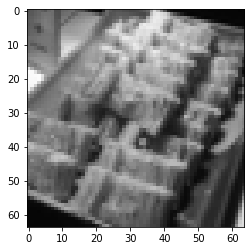

 26%|██▌       | 54/207 [00:13<00:49,  3.09it/s]

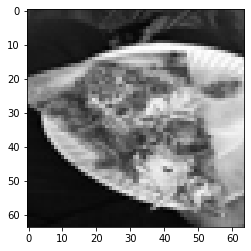

 27%|██▋       | 55/207 [00:13<00:43,  3.48it/s]

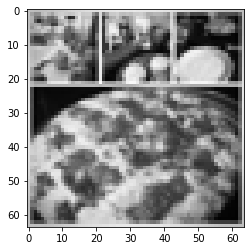

 27%|██▋       | 56/207 [00:14<00:41,  3.67it/s]

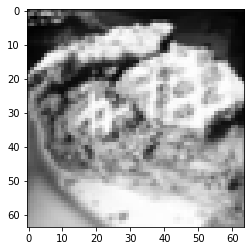

 28%|██▊       | 57/207 [00:14<00:51,  2.94it/s]

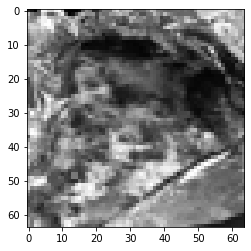

 28%|██▊       | 58/207 [00:14<00:47,  3.12it/s]

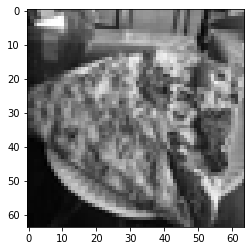

 29%|██▊       | 59/207 [00:15<00:44,  3.35it/s]

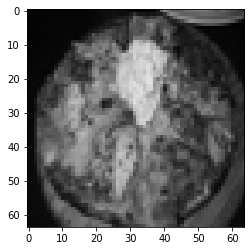

 29%|██▉       | 60/207 [00:15<00:41,  3.51it/s]

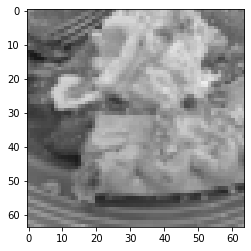

 29%|██▉       | 61/207 [00:15<00:46,  3.15it/s]

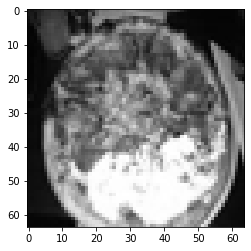

 30%|██▉       | 62/207 [00:15<00:41,  3.49it/s]

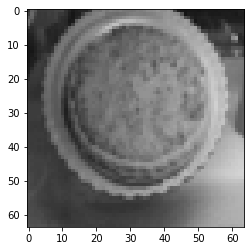

 30%|███       | 63/207 [00:16<00:41,  3.50it/s]

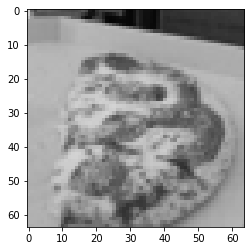

 31%|███       | 64/207 [00:16<00:39,  3.62it/s]

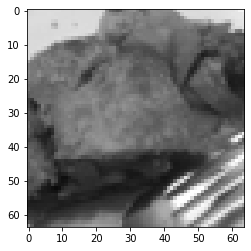

 31%|███▏      | 65/207 [00:16<00:39,  3.57it/s]

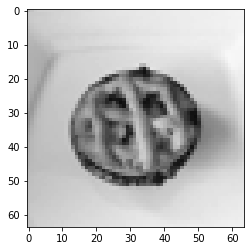

 32%|███▏      | 66/207 [00:17<00:39,  3.57it/s]

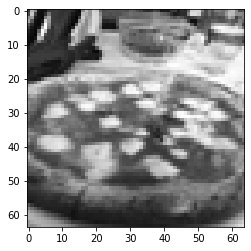

 32%|███▏      | 67/207 [00:17<00:36,  3.87it/s]

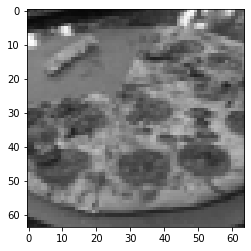

 33%|███▎      | 68/207 [00:17<00:35,  3.96it/s]

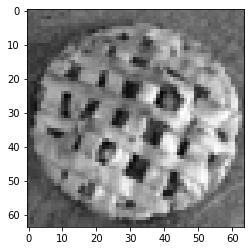

 33%|███▎      | 69/207 [00:17<00:36,  3.76it/s]

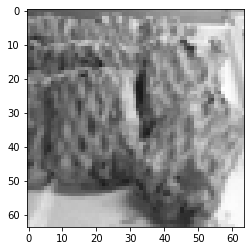

 34%|███▍      | 70/207 [00:18<00:36,  3.72it/s]

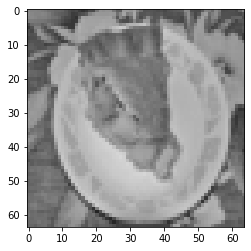

 34%|███▍      | 71/207 [00:18<00:34,  3.91it/s]

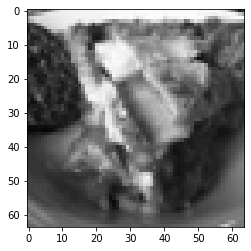

 35%|███▍      | 72/207 [00:18<00:34,  3.91it/s]

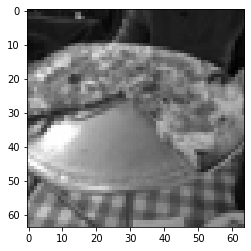

 35%|███▌      | 73/207 [00:18<00:32,  4.11it/s]

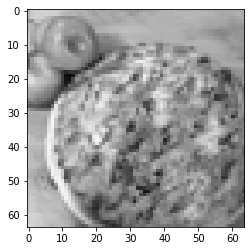

 36%|███▌      | 74/207 [00:19<00:38,  3.49it/s]

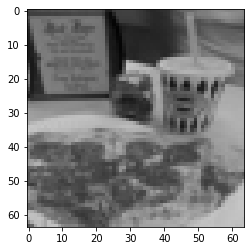

 36%|███▌      | 75/207 [00:19<00:37,  3.55it/s]

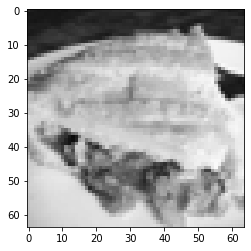

 37%|███▋      | 76/207 [00:19<00:34,  3.77it/s]

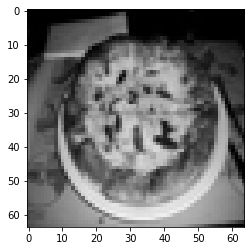

 37%|███▋      | 77/207 [00:19<00:33,  3.83it/s]

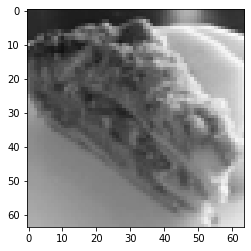

 38%|███▊      | 78/207 [00:20<00:34,  3.69it/s]

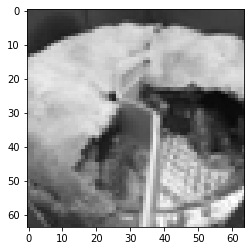

 38%|███▊      | 79/207 [00:20<00:36,  3.52it/s]

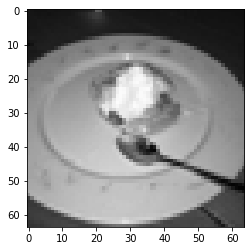

 39%|███▊      | 80/207 [00:20<00:33,  3.79it/s]

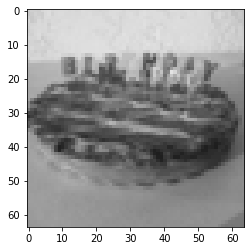

 39%|███▉      | 81/207 [00:20<00:31,  3.95it/s]

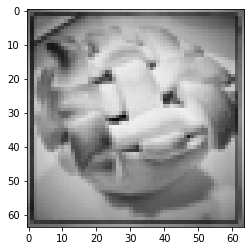

 40%|███▉      | 82/207 [00:21<00:30,  4.09it/s]

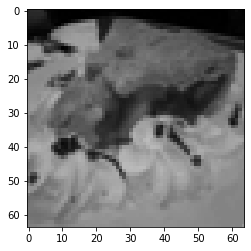

 40%|████      | 83/207 [00:21<00:32,  3.81it/s]

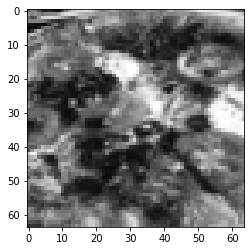

 41%|████      | 84/207 [00:21<00:30,  3.97it/s]

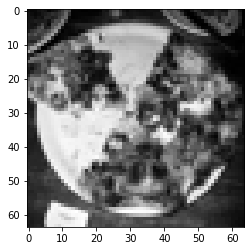

 41%|████      | 85/207 [00:21<00:29,  4.09it/s]

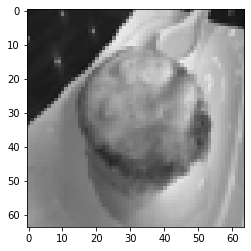

 42%|████▏     | 86/207 [00:22<00:27,  4.35it/s]

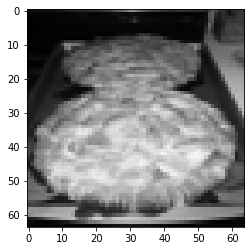

 42%|████▏     | 87/207 [00:22<00:32,  3.75it/s]

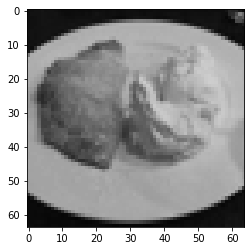

 43%|████▎     | 88/207 [00:22<00:28,  4.19it/s]

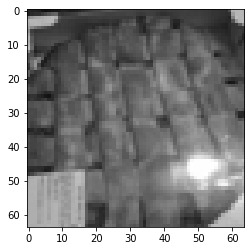

 43%|████▎     | 89/207 [00:22<00:25,  4.65it/s]

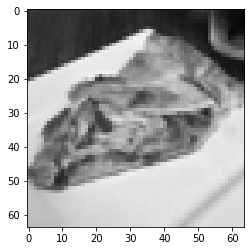

 43%|████▎     | 90/207 [00:23<00:24,  4.73it/s]

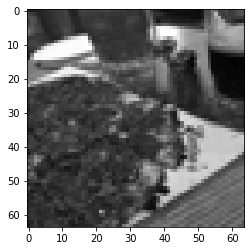

 44%|████▍     | 91/207 [00:23<00:24,  4.70it/s]

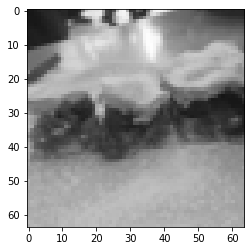

 44%|████▍     | 92/207 [00:23<00:23,  4.80it/s]

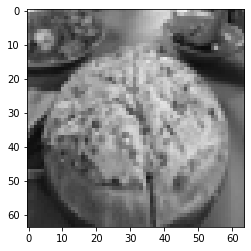

 45%|████▍     | 93/207 [00:23<00:23,  4.89it/s]

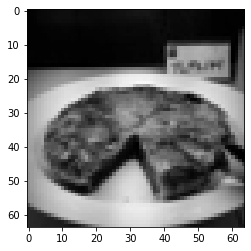

 45%|████▌     | 94/207 [00:23<00:22,  4.95it/s]

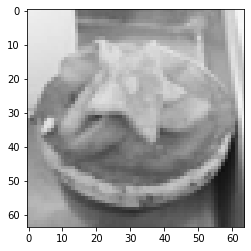

 46%|████▌     | 95/207 [00:24<00:22,  5.09it/s]

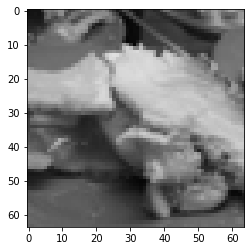

 46%|████▋     | 96/207 [00:24<00:22,  4.99it/s]

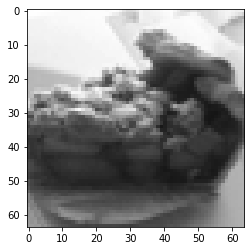

 47%|████▋     | 97/207 [00:24<00:21,  5.12it/s]

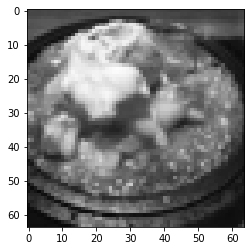

 47%|████▋     | 98/207 [00:24<00:20,  5.32it/s]

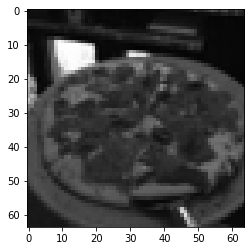

 48%|████▊     | 99/207 [00:24<00:20,  5.21it/s]

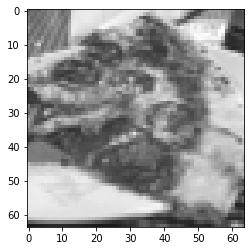

 48%|████▊     | 100/207 [00:25<00:25,  4.27it/s]

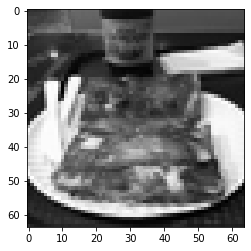

 49%|████▉     | 101/207 [00:25<00:24,  4.42it/s]

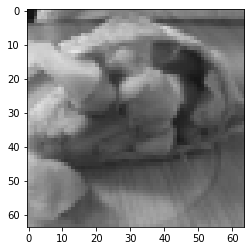

 49%|████▉     | 102/207 [00:25<00:23,  4.50it/s]

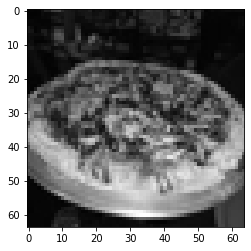

 50%|████▉     | 103/207 [00:25<00:23,  4.44it/s]

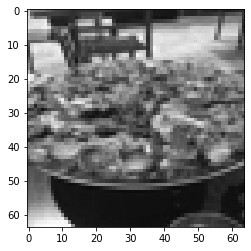

 50%|█████     | 104/207 [00:26<00:25,  4.12it/s]

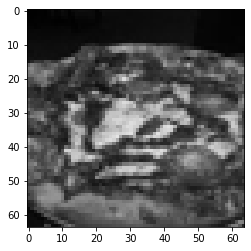

 51%|█████     | 105/207 [00:26<00:23,  4.40it/s]

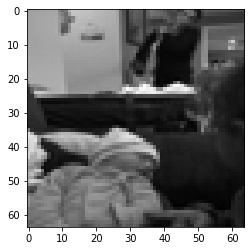

 51%|█████     | 106/207 [00:26<00:21,  4.71it/s]

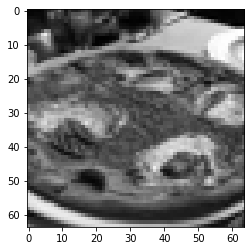

 52%|█████▏    | 107/207 [00:26<00:21,  4.59it/s]

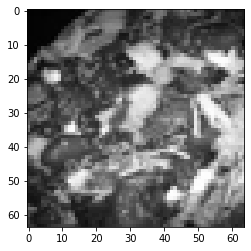

 52%|█████▏    | 108/207 [00:26<00:20,  4.84it/s]

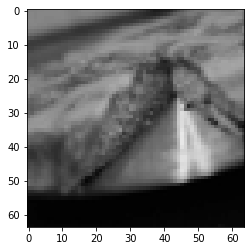

 53%|█████▎    | 109/207 [00:27<00:20,  4.85it/s]

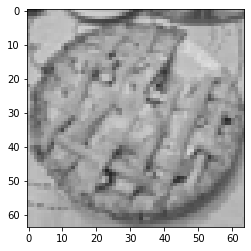

 53%|█████▎    | 110/207 [00:27<00:19,  4.89it/s]

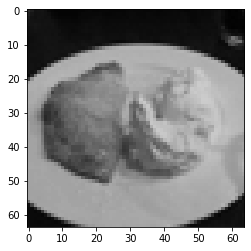

 54%|█████▎    | 111/207 [00:27<00:20,  4.61it/s]

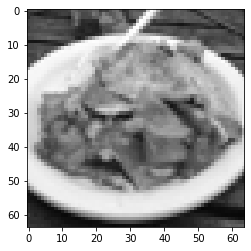

 54%|█████▍    | 112/207 [00:27<00:20,  4.72it/s]

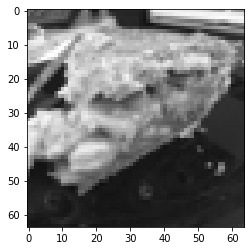

 55%|█████▍    | 113/207 [00:27<00:21,  4.44it/s]

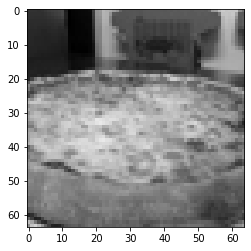

 55%|█████▌    | 114/207 [00:28<00:19,  4.81it/s]

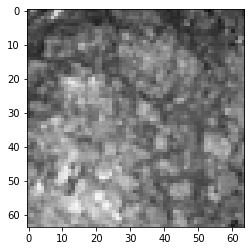

 56%|█████▌    | 115/207 [00:28<00:21,  4.24it/s]

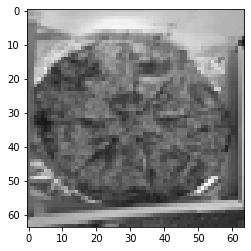

 56%|█████▌    | 116/207 [00:28<00:20,  4.53it/s]

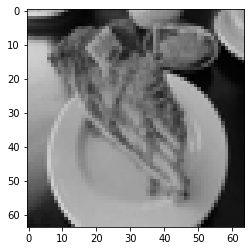

 57%|█████▋    | 117/207 [00:28<00:18,  4.87it/s]

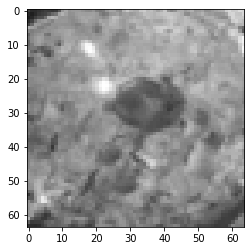

 57%|█████▋    | 118/207 [00:28<00:17,  5.18it/s]

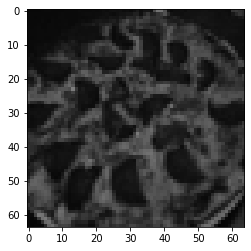

 57%|█████▋    | 119/207 [00:29<00:18,  4.85it/s]

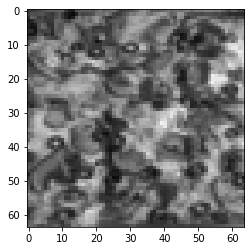

 58%|█████▊    | 120/207 [00:29<00:17,  4.94it/s]

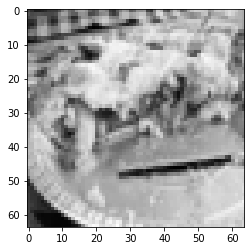

 58%|█████▊    | 121/207 [00:29<00:16,  5.06it/s]

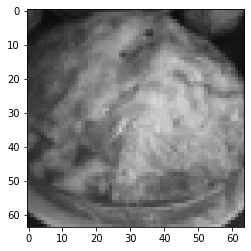

 59%|█████▉    | 122/207 [00:29<00:17,  4.84it/s]

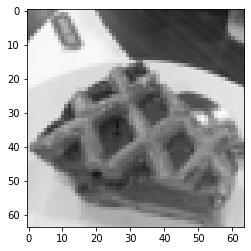

 59%|█████▉    | 123/207 [00:29<00:16,  5.11it/s]

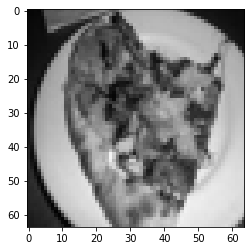

 60%|█████▉    | 124/207 [00:30<00:15,  5.28it/s]

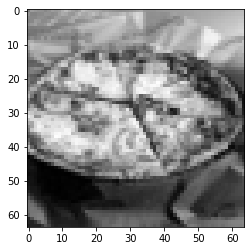

 60%|██████    | 125/207 [00:30<00:16,  4.97it/s]

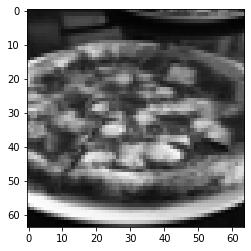

 61%|██████    | 126/207 [00:30<00:19,  4.10it/s]

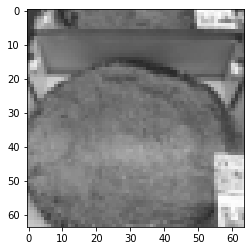

 61%|██████▏   | 127/207 [00:30<00:17,  4.50it/s]

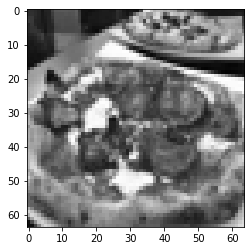

 62%|██████▏   | 128/207 [00:31<00:18,  4.29it/s]

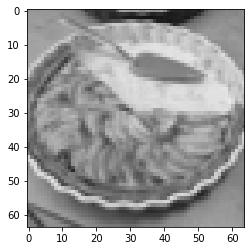

 62%|██████▏   | 129/207 [00:31<00:16,  4.71it/s]

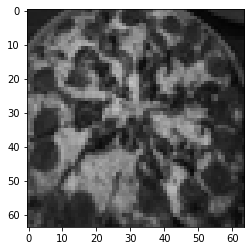

 63%|██████▎   | 130/207 [00:31<00:15,  5.10it/s]

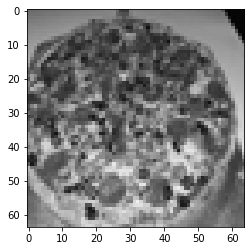

 63%|██████▎   | 131/207 [00:31<00:15,  5.05it/s]

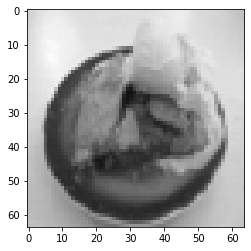

 64%|██████▍   | 132/207 [00:31<00:14,  5.05it/s]

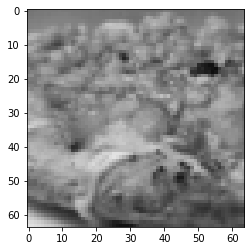

 64%|██████▍   | 133/207 [00:31<00:13,  5.39it/s]

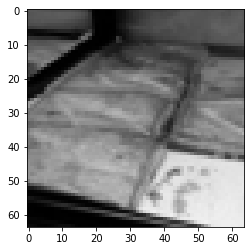

 65%|██████▍   | 134/207 [00:32<00:13,  5.32it/s]

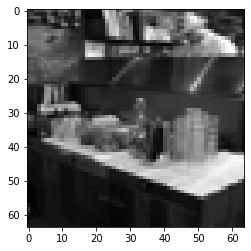

 65%|██████▌   | 135/207 [00:32<00:12,  5.55it/s]

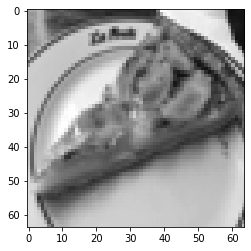

 66%|██████▌   | 136/207 [00:32<00:12,  5.70it/s]

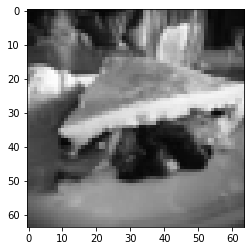

 66%|██████▌   | 137/207 [00:32<00:12,  5.55it/s]

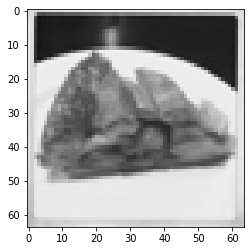

 67%|██████▋   | 138/207 [00:33<00:15,  4.49it/s]

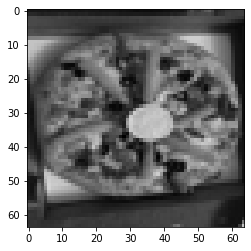

 67%|██████▋   | 139/207 [00:33<00:19,  3.55it/s]

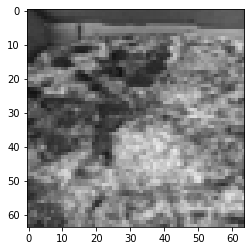

 68%|██████▊   | 140/207 [00:33<00:16,  4.09it/s]

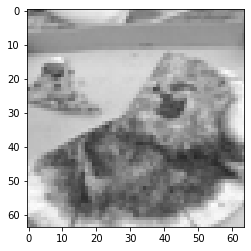

 68%|██████▊   | 141/207 [00:33<00:14,  4.44it/s]

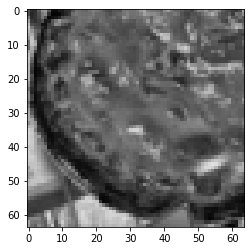

 69%|██████▊   | 142/207 [00:34<00:15,  4.16it/s]

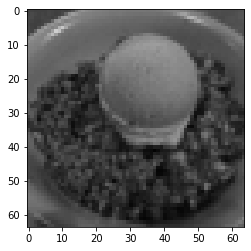

 69%|██████▉   | 143/207 [00:34<00:14,  4.48it/s]

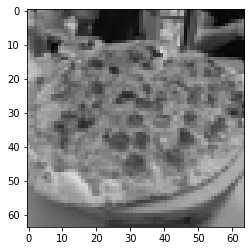

 70%|██████▉   | 144/207 [00:34<00:15,  4.08it/s]

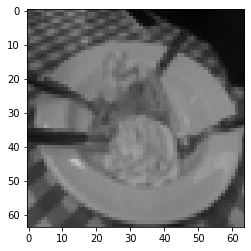

 70%|███████   | 145/207 [00:34<00:15,  3.95it/s]

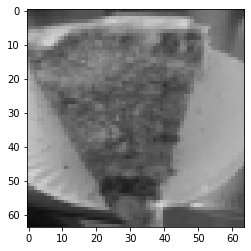

 71%|███████   | 146/207 [00:34<00:13,  4.47it/s]

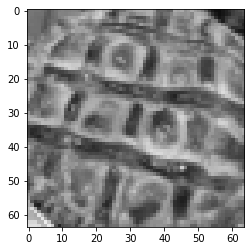

 71%|███████   | 147/207 [00:35<00:13,  4.53it/s]

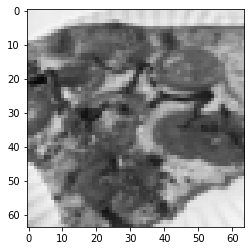

 71%|███████▏  | 148/207 [00:35<00:13,  4.28it/s]

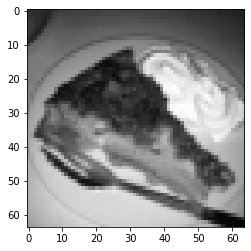

 72%|███████▏  | 149/207 [00:35<00:12,  4.67it/s]

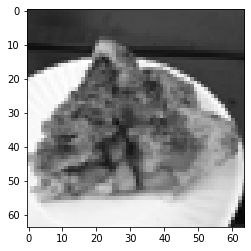

 72%|███████▏  | 150/207 [00:35<00:11,  4.90it/s]

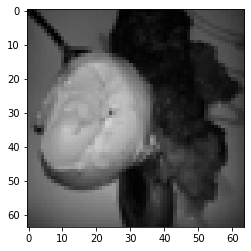

 73%|███████▎  | 151/207 [00:35<00:11,  4.94it/s]

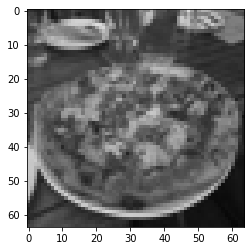

 73%|███████▎  | 152/207 [00:36<00:12,  4.40it/s]

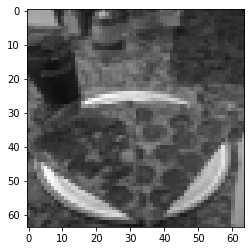

 74%|███████▍  | 153/207 [00:36<00:11,  4.64it/s]

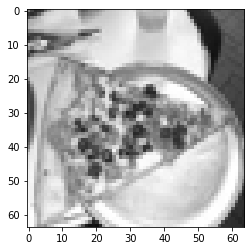

 74%|███████▍  | 154/207 [00:36<00:10,  4.84it/s]

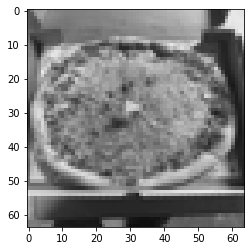

 75%|███████▍  | 155/207 [00:36<00:10,  5.11it/s]

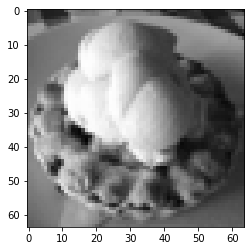

 75%|███████▌  | 156/207 [00:37<00:09,  5.19it/s]

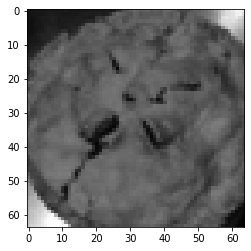

 76%|███████▌  | 157/207 [00:37<00:09,  5.30it/s]

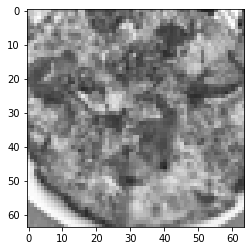

 76%|███████▋  | 158/207 [00:37<00:09,  5.38it/s]

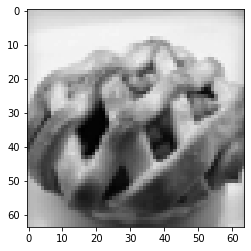

 77%|███████▋  | 159/207 [00:37<00:10,  4.39it/s]

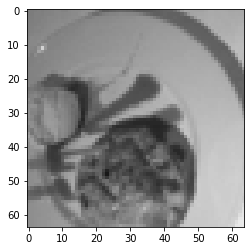

 77%|███████▋  | 160/207 [00:37<00:09,  4.74it/s]

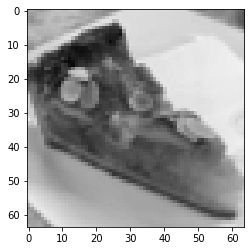

 78%|███████▊  | 161/207 [00:38<00:09,  4.70it/s]

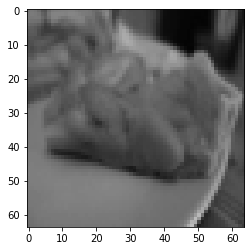

 78%|███████▊  | 162/207 [00:38<00:09,  4.87it/s]

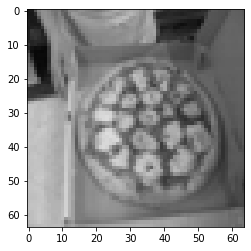

 79%|███████▊  | 163/207 [00:38<00:09,  4.79it/s]

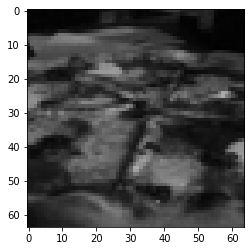

 79%|███████▉  | 164/207 [00:38<00:08,  5.18it/s]

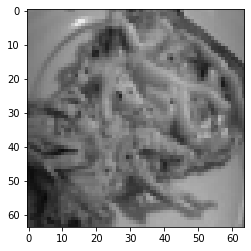

 80%|███████▉  | 165/207 [00:39<00:11,  3.74it/s]

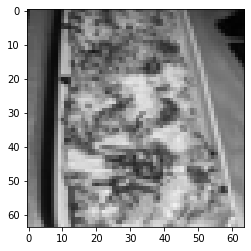

 80%|████████  | 166/207 [00:39<00:10,  3.91it/s]

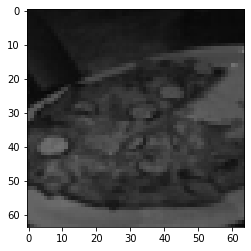

 81%|████████  | 167/207 [00:39<00:08,  4.47it/s]

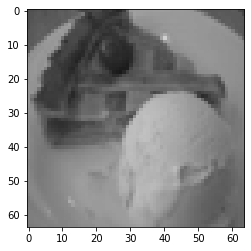

 81%|████████  | 168/207 [00:39<00:08,  4.51it/s]

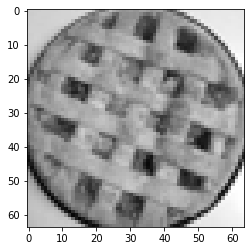

 82%|████████▏ | 169/207 [00:39<00:08,  4.49it/s]

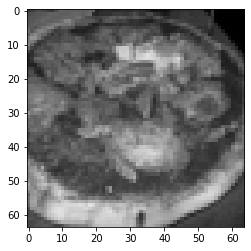

 82%|████████▏ | 170/207 [00:40<00:07,  4.76it/s]

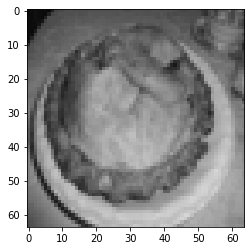

 83%|████████▎ | 171/207 [00:40<00:07,  4.86it/s]

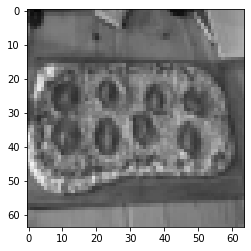

 83%|████████▎ | 172/207 [00:40<00:06,  5.28it/s]

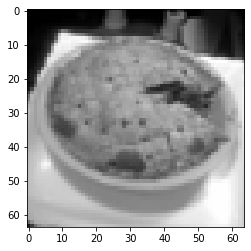

 84%|████████▎ | 173/207 [00:40<00:06,  5.25it/s]

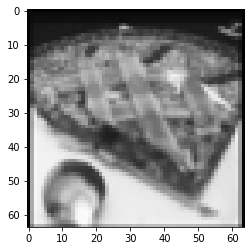

 84%|████████▍ | 174/207 [00:40<00:06,  5.06it/s]

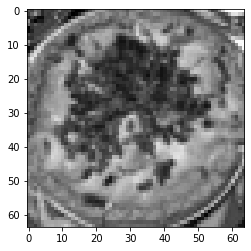

 85%|████████▍ | 175/207 [00:40<00:05,  5.56it/s]

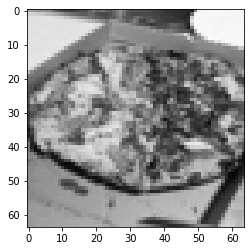

 85%|████████▌ | 176/207 [00:41<00:05,  5.26it/s]

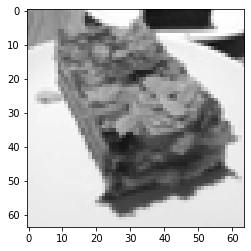

 86%|████████▌ | 177/207 [00:41<00:05,  5.66it/s]

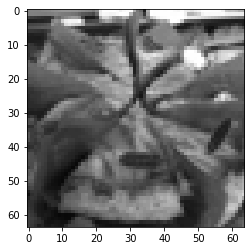

 86%|████████▌ | 178/207 [00:41<00:05,  5.03it/s]

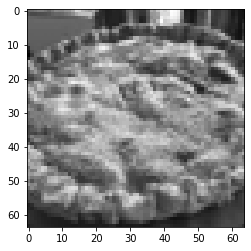

 86%|████████▋ | 179/207 [00:41<00:05,  5.10it/s]

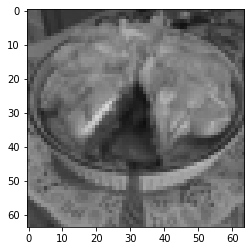

 87%|████████▋ | 180/207 [00:41<00:05,  5.32it/s]

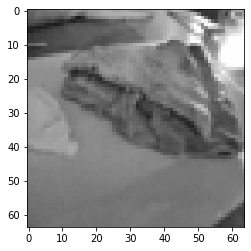

 87%|████████▋ | 181/207 [00:42<00:04,  5.35it/s]

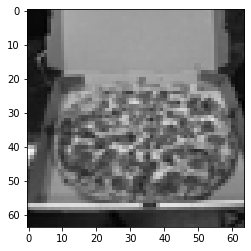

 88%|████████▊ | 182/207 [00:42<00:05,  4.52it/s]

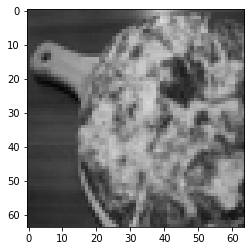

 88%|████████▊ | 183/207 [00:42<00:04,  4.92it/s]

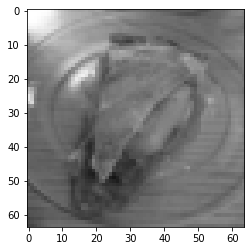

 89%|████████▉ | 184/207 [00:42<00:04,  5.24it/s]

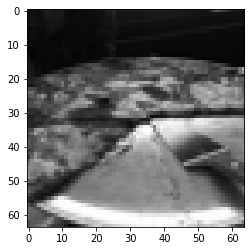

 89%|████████▉ | 185/207 [00:43<00:04,  4.41it/s]

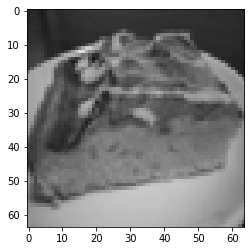

 90%|████████▉ | 186/207 [00:43<00:04,  4.78it/s]

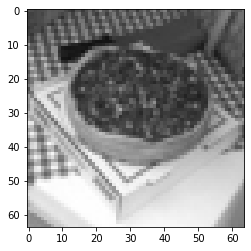

 90%|█████████ | 187/207 [00:43<00:04,  4.98it/s]

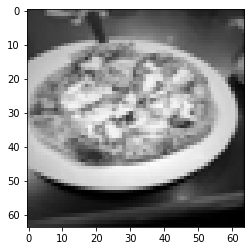

 91%|█████████ | 188/207 [00:43<00:03,  4.97it/s]

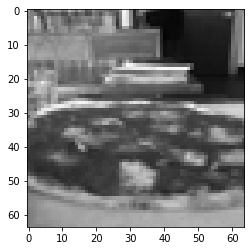

 91%|█████████▏| 189/207 [00:43<00:03,  5.20it/s]

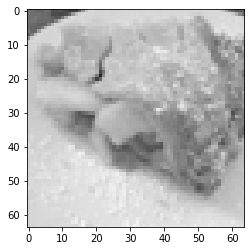

 92%|█████████▏| 190/207 [00:43<00:03,  5.21it/s]

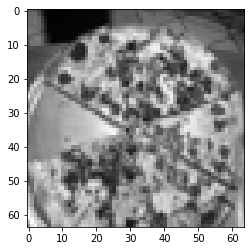

 92%|█████████▏| 191/207 [00:44<00:03,  4.22it/s]

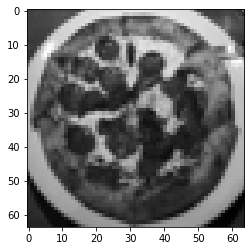

 93%|█████████▎| 192/207 [00:44<00:03,  4.12it/s]

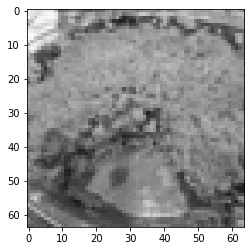

 93%|█████████▎| 193/207 [00:44<00:03,  4.43it/s]

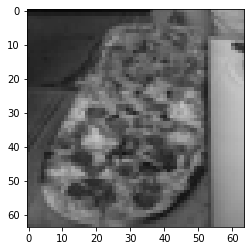

 94%|█████████▎| 194/207 [00:44<00:02,  4.74it/s]

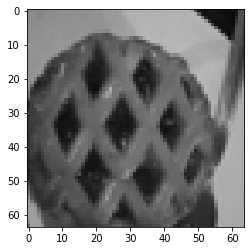

 94%|█████████▍| 195/207 [00:45<00:02,  4.52it/s]

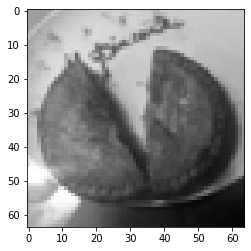

 95%|█████████▍| 196/207 [00:45<00:02,  4.67it/s]

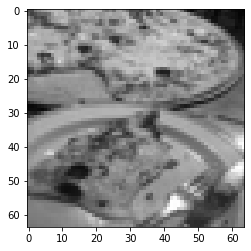

 95%|█████████▌| 197/207 [00:45<00:02,  4.86it/s]

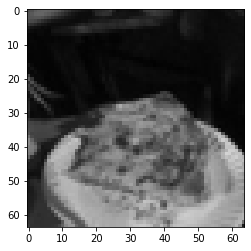

 96%|█████████▌| 198/207 [00:45<00:02,  4.29it/s]

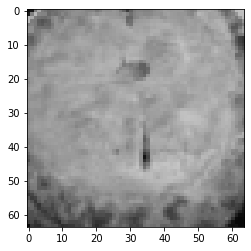

 96%|█████████▌| 199/207 [00:46<00:01,  4.27it/s]

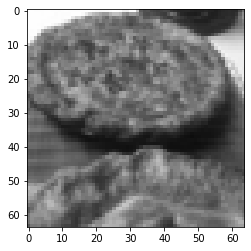

 97%|█████████▋| 200/207 [00:46<00:01,  4.52it/s]

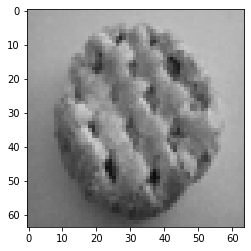

 97%|█████████▋| 201/207 [00:46<00:01,  4.49it/s]

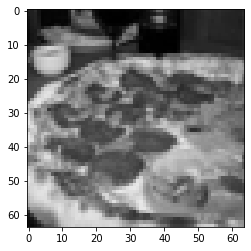

 98%|█████████▊| 202/207 [00:46<00:01,  4.66it/s]

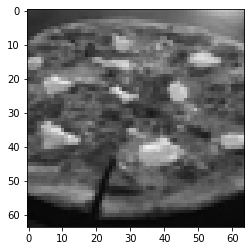

 98%|█████████▊| 203/207 [00:46<00:00,  4.35it/s]

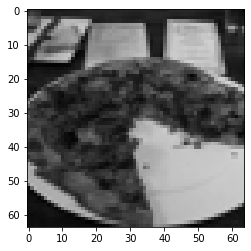

 99%|█████████▊| 204/207 [00:47<00:00,  4.07it/s]

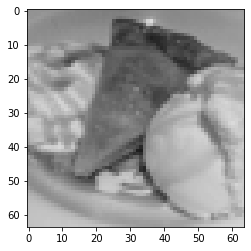

 99%|█████████▉| 205/207 [00:47<00:00,  4.09it/s]

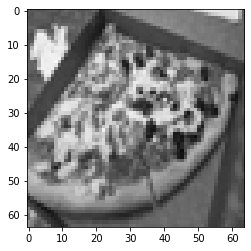

100%|█████████▉| 206/207 [00:47<00:00,  4.61it/s]

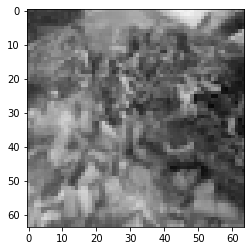

100%|██████████| 207/207 [00:47<00:00,  4.32it/s]


Iteration 0 with error = [0.50241546]
Iteration 100 with error = [0.49758454]
Iteration 200 with error = [0.49758454]
Iteration 300 with error = [0.49758454]
Iteration 400 with error = [0.50241546]
Iteration 500 with error = [0.50241546]
Iteration 600 with error = [0.49758454]
Iteration 700 with error = [0.49758454]
Iteration 800 with error = [0.49758454]
Iteration 900 with error = [0.50241546]


In [3]:
from tqdm import tqdm
from PIL import Image, ImageOps 
import os 
import matplotlib.pyplot as plt
import matplotlib.image as img

def preprocess_dataset(paths, img_size):
    list_X, list_Y, images = [], [], []
    for path in paths:
        images = images + [path + "/" + i for i in os.listdir(path)]

    np.random.shuffle(images)
    for filename in tqdm(images):
        if "." in filename:
            img = ImageOps.grayscale(Image.open(filename).resize(img_size))
            array = np.asarray(img).flatten().tolist()
            plt.imshow(img, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
            plt.show()

            list_X.append(array)

            if "pizza" in filename:
                class_array = [0]#[1,0,0]#0
            elif "tarte aux pommes" in filename:
                class_array = [1]#[0,1,0]#1
            elif "tarte aux fraises" in filename:
                class_array = [0,0,1]#2
            #On met 0,1,2 car nous sommes dans un modèle qui doit détecter plusieurs classes et on va renvoyer un tableau de proba (3 éléments)
            #On fait un OneHotEncoder à la main car nous possédons 3 labels

            list_Y.append(class_array)

    X, Y = np.array(list_X), np.array(list_Y)
    return X  / 255. ** 2, Y
X, Y = preprocess_dataset(["D:/Github/PROJET-ANNUEL-3IABD-SOLO/dataset/train/pizza",
                          "D:/Github/PROJET-ANNUEL-3IABD-SOLO/dataset/train/tarte aux pommes"
                          #"D:/Github/PROJET-ANNUEL-3IABD-SOLO/dataset/train/tarte aux fraises",
                          ],
                          (64, 64))

# Init the parameters for the network
clf = MultiLayerPerceptron(learning_rate = 1, num_iteration = 1000, is_Classifier = True)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1 , is_sigmoid=True)
clf.add_hidden_layer(num_neuron = 5)
clf.add_hidden_layer(num_neuron = 20)

#print(len(X[0]))
#print(Y)
# Train the network
clf.train(X,Y)

In [ ]:
Xtest, Ytest = preprocess_dataset(["D:/Github/PROJET-ANNUEL-3IABD-SOLO/dataset/test/pizza",
                          "D:/Github/PROJET-ANNUEL-3IABD-SOLO/dataset/test/tarte aux pommes",
                          "D:/Github/PROJET-ANNUEL-3IABD-SOLO/dataset/test/tarte aux fraises",],
                          (16, 16))
clf.validate(Xtest,Ytest)